In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
PROCESSED_FEATURES_DIR = "../processed_features"
SEQUENCE_LENGTH = 15
BATCH_SIZE = 16
HIDDEN_SIZE = 64
NUM_LAYERS = 2
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
CLASS_NAMES = ["awake", "light_drowsy", "severe_drowsy", "distracted"]
NUM_CLASSES = len(CLASS_NAMES)

In [4]:
class SequenceDataset(Dataset):
    """时间序列数据集"""

    def __init__(self, sequences, labels):
        self.sequences = torch.FloatTensor(sequences)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [5]:
class LSTMModel(nn.Module):
    """LSTM分类模型"""

    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM输出
        out, _ = self.lstm(x, (h0, c0))

        # 取最后一个时间步的输出
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [6]:
from collections import defaultdict
import random


def process_files_to_sequences(file_list, data_dir, seq_length):
    """读取文件列表并转换为序列数据"""
    sequences = []
    labels = []

    for filename in tqdm(file_list, desc="Processing files"):
        # 移除 .npy 后缀
        name_without_ext = filename[:-4]

        # 尝试匹配类别
        category = None
        for class_name in CLASS_NAMES:
            if name_without_ext.startswith(class_name):
                category = class_name
                break

        if category is None:
            continue

        label = CLASS_NAMES.index(category)

        # 加载特征
        features = np.load(os.path.join(data_dir, filename))

        # 滑动窗口生成序列
        for i in range(len(features) - seq_length + 1):
            seq = features[i : i + seq_length]
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)


# ==========================================
# 核心修改:按类别+主体分组,确保原始和增强文件在同一集
# ==========================================

all_files = [f for f in os.listdir(PROCESSED_FEATURES_DIR) if f.endswith(".npy")]

# 第一步:按类别分组
files_by_class = defaultdict(list)
for f in all_files:
    for class_name in CLASS_NAMES:
        if f.startswith(class_name):
            files_by_class[class_name].append(f)
            break

# 第二步:在每个类别内部,按"主体"分组
train_files = []
test_files = []

for class_name, file_list in files_by_class.items():
    # 建立主体组字典
    subject_groups = defaultdict(list)

    for f in file_list:
        # 去掉类别前缀和.npy后缀,得到主体标识部分
        # 例如: awake_A_aug0.npy -> A_aug0 -> A
        # 例如: awake_aug5.npy -> aug5 -> (无主体,视为独立)
        base_name = f[len(class_name) + 1 : -4]  # 去掉 "awake_" 和 ".npy"

        if "_aug" in base_name:
            # 如果有 _aug,提取主体ID (aug前面的部分)
            subject_id = base_name.split("_aug")[0]
        else:
            subject_id = base_name  # 原始文件的主体ID

        # 特殊处理:如果没有主体ID (如 awake_aug5.npy -> subject_id=''),每个文件单独一组
        if subject_id == "":
            subject_groups[f].append(f)  # 用文件名本身作为组key
        else:
            subject_groups[subject_id].append(f)

    # 第三步:随机划分组 (80% train, 20% test)
    subject_keys = list(subject_groups.keys())
    random.seed(42)  # 固定随机种子保证可复现
    random.shuffle(subject_keys)

    split_idx = int(len(subject_keys) * 0.8)
    train_subjects = subject_keys[:split_idx]
    test_subjects = subject_keys[split_idx:]

    # 展开回文件列表
    for subject in train_subjects:
        train_files.extend(subject_groups[subject])

    for subject in test_subjects:
        test_files.extend(subject_groups[subject])

    print(
        f"{class_name}: 训练主体 {len(train_subjects)} 个, 测试主体 {len(test_subjects)} 个"
    )

print(f"\n总训练集文件数: {len(train_files)}")
print(f"总测试集文件数: {len(test_files)}")

# 生成序列数据
print("\n生成训练数据...")
X_train, y_train = process_files_to_sequences(
    train_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH
)
print("\n生成测试数据...")
X_test, y_test = process_files_to_sequences(
    test_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH
)

# 数据标准化
mean = X_train.mean(axis=(0, 1))
std = X_train.std(axis=(0, 1)) + 1e-6

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

np.save("normalization_params.npy", {"mean": mean, "std": std})

print(f"\n最终数据集形状:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

awake: 训练主体 18 个, 测试主体 5 个
distracted: 训练主体 47 个, 测试主体 12 个
light_drowsy: 训练主体 16 个, 测试主体 4 个
severe_drowsy: 训练主体 56 个, 测试主体 15 个

总训练集文件数: 254
总测试集文件数: 66

生成训练数据...


Processing files: 100%|██████████| 254/254 [00:00<00:00, 2349.56it/s]



生成测试数据...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2289.96it/s]



最终数据集形状:
X_train: (188529, 15, 7)
X_test: (55272, 15, 7)


[I 2025-12-18 00:27:23,089] A new study created in memory with name: no-name-fca6ccb5-a7d7-4816-943f-1ffb5612c7c2


开始超参数优化 (Optuna)


  0%|          | 0/10 [00:00<?, ?it/s]


[Trial 0] 生成序列数据 (seq_len=10)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2513.22it/s]


  Early stopping at epoch 14
[I 2025-12-18 00:33:36,621] Trial 0 finished with value: 80.02769684543722 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'learning_rate': 0.00013066739238053285, 'batch_size': 16, 'weight_decay': 1.0994335574766187e-05, 'sequence_length': 10}. Best is trial 0 with value: 80.02769684543722.

[Trial 1] 生成序列数据 (seq_len=20)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2366.40it/s]


  Early stopping at epoch 6
[I 2025-12-18 00:34:25,655] Trial 1 finished with value: 80.05533107640785 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.5, 'learning_rate': 0.00019010245319870352, 'batch_size': 64, 'weight_decay': 0.00037183641805732076, 'sequence_length': 20}. Best is trial 1 with value: 80.05533107640785.

[Trial 2] 生成序列数据 (seq_len=20)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2677.16it/s]


  Early stopping at epoch 9
[I 2025-12-18 00:40:18,282] Trial 2 finished with value: 84.01405118124568 and parameters: {'hidden_size': 256, 'num_layers': 3, 'dropout': 0.6, 'learning_rate': 0.0004066563313514797, 'batch_size': 32, 'weight_decay': 1.7541893487450798e-05, 'sequence_length': 20}. Best is trial 2 with value: 84.01405118124568.

[Trial 3] 生成序列数据 (seq_len=30)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2747.93it/s]


  Early stopping at epoch 6
[I 2025-12-18 00:42:54,384] Trial 3 finished with value: 86.89068199403117 and parameters: {'hidden_size': 32, 'num_layers': 1, 'dropout': 0.6, 'learning_rate': 0.0035503048581283078, 'batch_size': 16, 'weight_decay': 0.0006978281265126031, 'sequence_length': 30}. Best is trial 3 with value: 86.89068199403117.

[Trial 4] 生成序列数据 (seq_len=20)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2735.85it/s]


  Early stopping at epoch 18
[I 2025-12-18 00:45:20,363] Trial 4 finished with value: 84.96960430999964 and parameters: {'hidden_size': 128, 'num_layers': 1, 'dropout': 0.4, 'learning_rate': 0.00019135880487692312, 'batch_size': 64, 'weight_decay': 0.0003503398491158688, 'sequence_length': 20}. Best is trial 3 with value: 86.89068199403117.

[Trial 5] 生成序列数据 (seq_len=20)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2561.95it/s]


  Early stopping at epoch 12
[I 2025-12-18 00:50:40,031] Trial 5 finished with value: 85.27356121000328 and parameters: {'hidden_size': 64, 'num_layers': 1, 'dropout': 0.6, 'learning_rate': 0.0017643967683381545, 'batch_size': 16, 'weight_decay': 4.4706085467784903e-05, 'sequence_length': 20}. Best is trial 3 with value: 86.89068199403117.

[Trial 6] 生成序列数据 (seq_len=30)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2608.13it/s]


  Early stopping at epoch 7
[I 2025-12-18 00:55:23,994] Trial 6 finished with value: 82.39379536494602 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.4, 'learning_rate': 0.0011103647313054626, 'batch_size': 16, 'weight_decay': 1.1557352816269867e-05, 'sequence_length': 30}. Best is trial 3 with value: 86.89068199403117.

[Trial 7] 生成序列数据 (seq_len=20)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2537.58it/s]


[I 2025-12-18 00:57:56,323] Trial 7 pruned. 

[Trial 8] 生成序列数据 (seq_len=30)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2383.46it/s]


[I 2025-12-18 00:59:35,446] Trial 8 pruned. 

[Trial 9] 生成序列数据 (seq_len=10)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2537.67it/s]


  Early stopping at epoch 13
[I 2025-12-18 01:07:02,005] Trial 9 finished with value: 85.11744181863962 and parameters: {'hidden_size': 128, 'num_layers': 3, 'dropout': 0.6, 'learning_rate': 0.00031883397351001905, 'batch_size': 16, 'weight_decay': 1.1851515660043103e-05, 'sequence_length': 10}. Best is trial 3 with value: 86.89068199403117.

优化完成!

最佳验证准确率: 86.89%

最佳超参数组合:
  hidden_size: 32
  num_layers: 1
  dropout: 0.6
  learning_rate: 0.0035503048581283078
  batch_size: 16
  weight_decay: 0.0006978281265126031
  sequence_length: 30


C:\Users\HP\AppData\Local\Temp\ipykernel_19796\3940978829.py:205: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


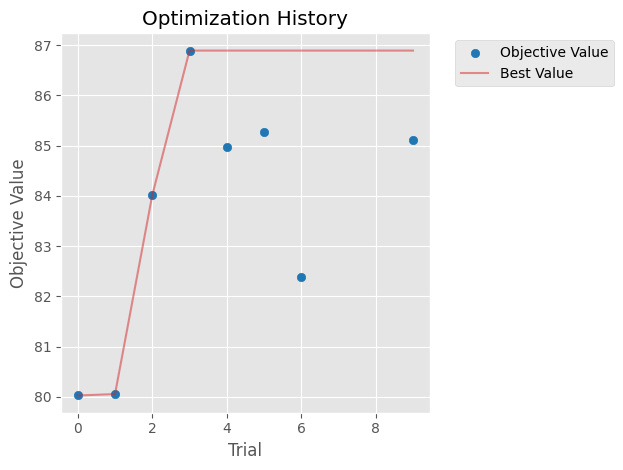

C:\Users\HP\AppData\Local\Temp\ipykernel_19796\3940978829.py:211: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


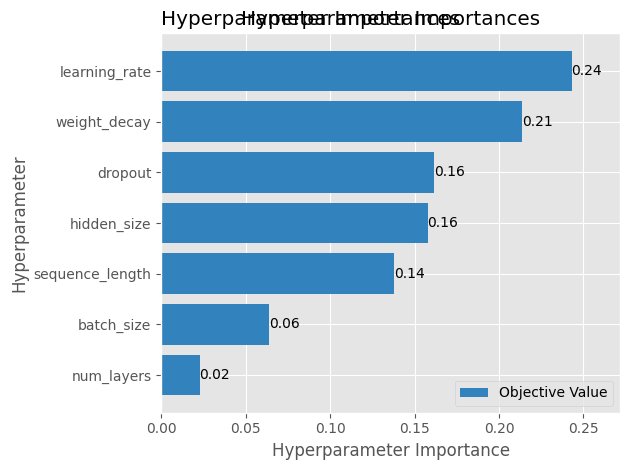

C:\Users\HP\AppData\Local\Temp\ipykernel_19796\3940978829.py:217: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_parallel_coordinate(study)


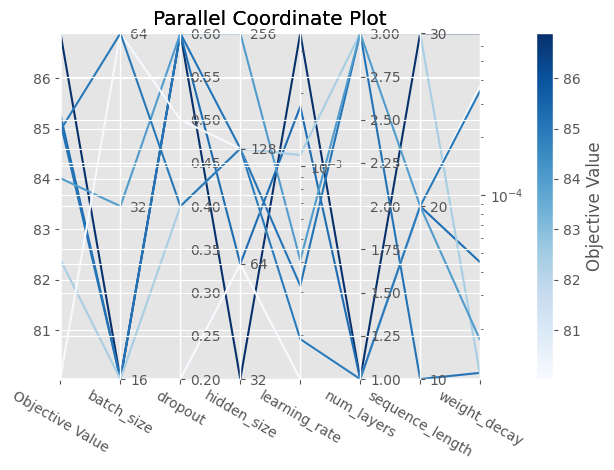

C:\Users\HP\AppData\Local\Temp\ipykernel_19796\3940978829.py:223: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_slice(study)
C:\Users\HP\AppData\Local\Temp\ipykernel_19796\3940978829.py:224: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


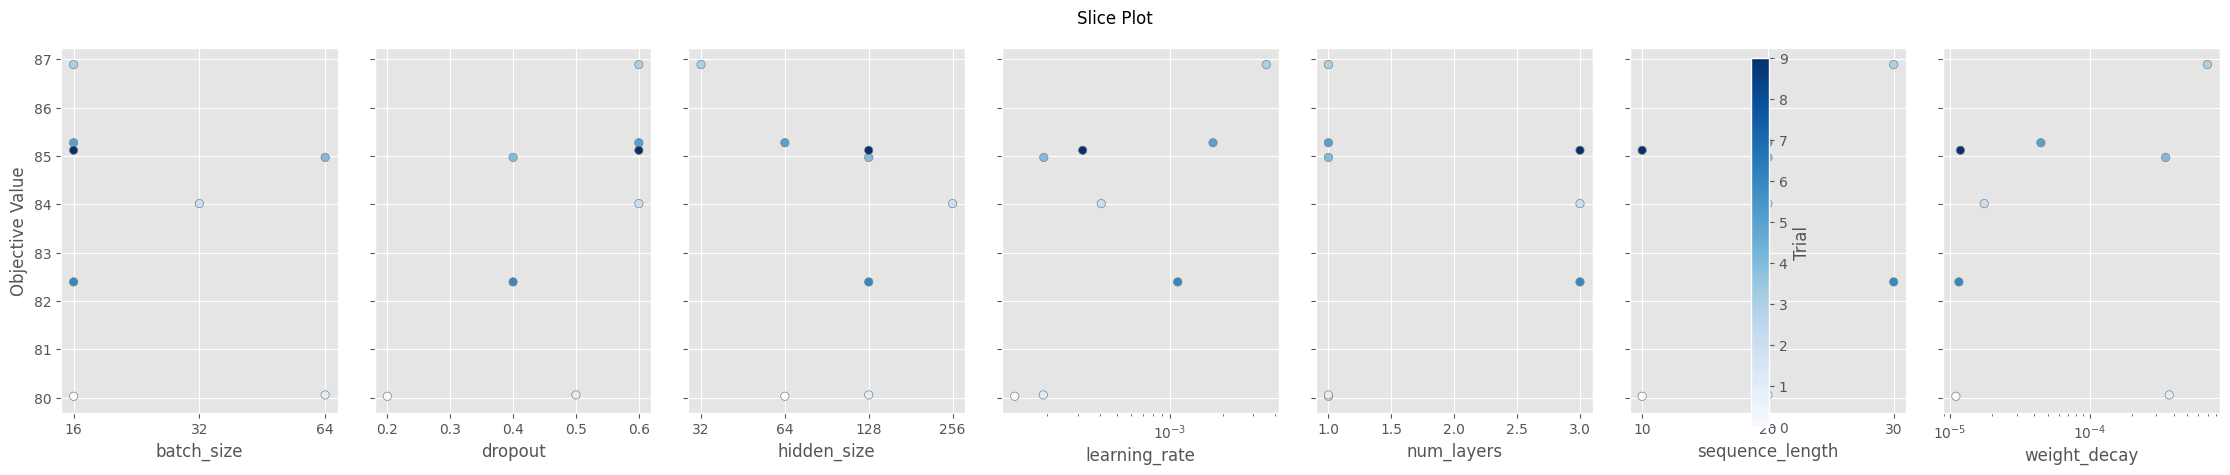


最佳参数已保存到: best_hyperparameters.json
Study 对象已保存到: optuna_study.pkl


In [7]:
"""使用 Optuna 进行超参数优化"""

import optuna
from optuna.trial import Trial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np


# 定义优化目标函数
def objective(trial: Trial):
    """Optuna 优化目标函数"""

    # ==========================================
    # 1. 超参数搜索空间定义
    # ==========================================

    # 模型架构参数
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.6, step=0.1)

    # 训练参数
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

    # 序列长度
    sequence_length = trial.suggest_categorical("sequence_length", [10, 15, 20, 30])

    # ==========================================
    # 2. 重新生成序列数据 (根据新的 sequence_length)
    # ==========================================
    print(f"\n[Trial {trial.number}] 生成序列数据 (seq_len={sequence_length})...")

    X_train_opt, y_train_opt = process_files_to_sequences(
        train_files, PROCESSED_FEATURES_DIR, sequence_length
    )
    X_test_opt, y_test_opt = process_files_to_sequences(
        test_files, PROCESSED_FEATURES_DIR, sequence_length
    )

    # 数据标准化
    mean = X_train_opt.mean(axis=(0, 1))
    std = X_train_opt.std(axis=(0, 1)) + 1e-6
    X_train_opt = (X_train_opt - mean) / std
    X_test_opt = (X_test_opt - mean) / std

    # ==========================================
    # 3. 创建数据加载器
    # ==========================================
    train_dataset = SequenceDataset(X_train_opt, y_train_opt)
    test_dataset = SequenceDataset(X_test_opt, y_test_opt)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Windows 下设置为 0
        pin_memory=True if torch.cuda.is_available() else False,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False,
    )

    # ==========================================
    # 4. 创建模型
    # ==========================================
    input_size = X_train_opt.shape[2]
    model = LSTMModel(
        input_size, hidden_size, num_layers, NUM_CLASSES, dropout=dropout
    ).to(DEVICE)

    # ==========================================
    # 5. 损失函数和优化器
    # ==========================================
    # 计算类别权重 (解决类别不平衡问题)
    class_counts = np.bincount(y_train_opt)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    class_weights = torch.FloatTensor(class_weights).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay
    )

    # 学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="max",  # 监控验证准确率 (越大越好)
        factor=0.5,
        patience=3,
    )

    # ==========================================
    # 6. 训练循环 (Early Stopping)
    # ==========================================
    best_val_acc = 0
    patience_counter = 0
    max_patience = 5
    num_epochs = 20  # 允许更多 epoch,依靠 early stopping

    for epoch in range(num_epochs):
        # 训练
        model.train()
        for sequences, labels in train_loader:
            sequences = sequences.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 验证
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sequences, labels in test_loader:
                sequences = sequences.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(sequences)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100.0 * correct / total

        # Early Stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break

        # 学习率调整
        scheduler.step(val_acc)

        # 向 Optuna 报告中间结果 (支持剪枝)
        trial.report(val_acc, epoch)

        # 检查是否应该剪枝
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 清理内存
    del model, optimizer, train_loader, test_loader
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    return best_val_acc


# ==========================================
# 7. 创建 Optuna Study 并开始优化
# ==========================================
print("=" * 60)
print("开始超参数优化 (Optuna)")
print("=" * 60)

# 创建 Study (使用 TPE 采样器和 Median 剪枝器)
study = optuna.create_study(
    direction="maximize",  # 最大化验证准确率
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,  # 前5次试验不剪枝
        n_warmup_steps=3,  # 每次试验的前3个epoch不剪枝
    ),
)

# 运行优化
study.optimize(
    objective, n_trials=10, timeout=None, show_progress_bar=True  # 可以根据计算资源调整
)

# ==========================================
# 8. 输出优化结果
# ==========================================
print("\n" + "=" * 60)
print("优化完成!")
print("=" * 60)

print(f"\n最佳验证准确率: {study.best_value:.2f}%")
print(f"\n最佳超参数组合:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ==========================================
# 9. 可视化优化过程
# ==========================================
import matplotlib.pyplot as plt

# 9.1 优化历史
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.tight_layout()
plt.show()

# 9.2 参数重要性
fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Hyperparameter Importances")
plt.tight_layout()
plt.show()

# 9.3 并行坐标图 (展示不同参数组合的效果)
fig = optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.tight_layout()
plt.show()

# 9.4 切片图 (每个参数的影响)
fig = optuna.visualization.matplotlib.plot_slice(study)
plt.tight_layout()
plt.show()

# ==========================================
# 10. 保存优化结果
# ==========================================
# 保存最佳参数到文件
best_params_path = "best_hyperparameters.json"
import json

with open(best_params_path, "w") as f:
    json.dump(study.best_params, f, indent=4)
print(f"\n最佳参数已保存到: {best_params_path}")

# 保存完整的 study 对象 (可以后续继续优化)
study_path = "optuna_study.pkl"
import joblib

joblib.dump(study, study_path)
print(f"Study 对象已保存到: {study_path}")

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in dataloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100*correct / total

    return avg_loss, accuracy

In [9]:
def validate(model, dataloader, criterion, device):
    """验证模型"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in dataloader:
            sequences = sequences.to(device)
            labels = labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100*correct / total

    return avg_loss, accuracy

使用最佳超参数训练完整模型:
{
  "hidden_size": 32,
  "num_layers": 1,
  "dropout": 0.6,
  "learning_rate": 0.0035503048581283078,
  "batch_size": 16,
  "weight_decay": 0.0006978281265126031,
  "sequence_length": 30
}

生成序列数据 (seq_len=30)...


Processing files: 100%|██████████| 66/66 [00:00<00:00, 2568.89it/s]



开始训练 (共 30 epochs)...
Epoch [1/30]
  Train Loss: 0.2206, Train Acc: 92.12%
  Val Loss: 0.8475, Val Acc: 68.99%
  ✓ 保存最佳模型 (Val Acc: 68.99%)
Epoch [2/30]
  Train Loss: 0.1587, Train Acc: 94.67%
  Val Loss: 0.6018, Val Acc: 83.26%
  ✓ 保存最佳模型 (Val Acc: 83.26%)
Epoch [3/30]
  Train Loss: 0.1314, Train Acc: 95.86%
  Val Loss: 0.8339, Val Acc: 77.59%
Epoch [4/30]
  Train Loss: 0.1158, Train Acc: 96.46%
  Val Loss: 0.5936, Val Acc: 82.11%
Epoch [5/30]
  Train Loss: 0.1028, Train Acc: 96.95%
  Val Loss: 0.6859, Val Acc: 82.95%
Epoch [6/30]
  Train Loss: 0.1016, Train Acc: 96.94%
  Val Loss: 0.7404, Val Acc: 81.16%
Epoch [7/30]
  Train Loss: 0.0958, Train Acc: 97.19%
  Val Loss: 0.8167, Val Acc: 83.13%
Epoch [8/30]
  Train Loss: 0.1038, Train Acc: 96.93%
  Val Loss: 0.6704, Val Acc: 82.38%
Epoch [9/30]
  Train Loss: 0.0558, Train Acc: 98.52%
  Val Loss: 0.9835, Val Acc: 80.96%
Epoch [10/30]
  Train Loss: 0.0532, Train Acc: 98.58%
  Val Loss: 0.9308, Val Acc: 82.47%
Epoch [11/30]
  Train Loss: 

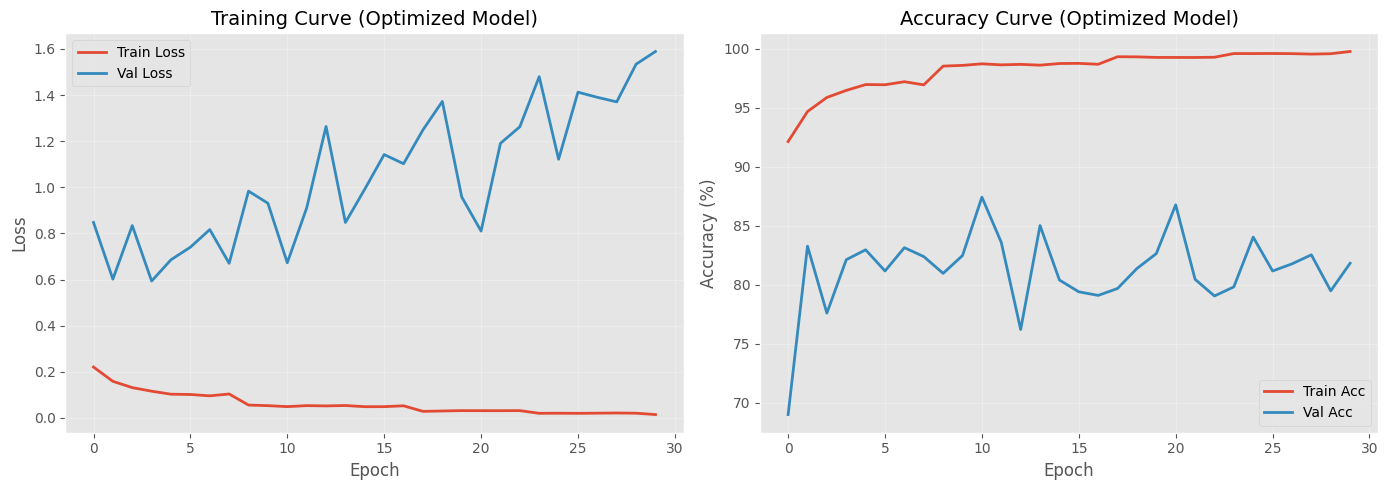


🎉 最终最佳验证准确率: 87.41%


In [10]:
"""使用最佳参数重新训练完整模型"""

import json

# 加载最佳参数
with open("best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("使用最佳超参数训练完整模型:")
print(json.dumps(best_params, indent=2))

# ==========================================
# 1. 使用最佳参数重新生成数据
# ==========================================
SEQUENCE_LENGTH_BEST = best_params["sequence_length"]
BATCH_SIZE_BEST = best_params["batch_size"]
HIDDEN_SIZE_BEST = best_params["hidden_size"]
NUM_LAYERS_BEST = best_params["num_layers"]
DROPOUT_BEST = best_params["dropout"]
LEARNING_RATE_BEST = best_params["learning_rate"]
WEIGHT_DECAY_BEST = best_params["weight_decay"]

print(f"\n生成序列数据 (seq_len={SEQUENCE_LENGTH_BEST})...")
X_train_final, y_train_final = process_files_to_sequences(
    train_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH_BEST
)
X_test_final, y_test_final = process_files_to_sequences(
    test_files, PROCESSED_FEATURES_DIR, SEQUENCE_LENGTH_BEST
)

# 标准化
mean_final = X_train_final.mean(axis=(0, 1))
std_final = X_train_final.std(axis=(0, 1)) + 1e-6
X_train_final = (X_train_final - mean_final) / std_final
X_test_final = (X_test_final - mean_final) / std_final

weight_factor=15.0
X_train_final[:,:,4:]*=weight_factor
X_test_final[:,:,4:]*=weight_factor
# 保存标准化参数
np.save("normalization_params_best.npy", {"mean": mean_final, "std": std_final})

# ==========================================
# 2. 创建最终模型
# ==========================================
train_dataset_final = SequenceDataset(X_train_final, y_train_final)
test_dataset_final = SequenceDataset(X_test_final, y_test_final)

train_loader_final = DataLoader(
    train_dataset_final, batch_size=BATCH_SIZE_BEST, shuffle=True
)
test_loader_final = DataLoader(
    test_dataset_final, batch_size=BATCH_SIZE_BEST, shuffle=False
)

input_size = X_train_final.shape[2]
model_final = LSTMModel(
    input_size, HIDDEN_SIZE_BEST, NUM_LAYERS_BEST, NUM_CLASSES, dropout=DROPOUT_BEST
).to(DEVICE)

# 计算类别权重
class_counts = np.bincount(y_train_final)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
class_weights = torch.FloatTensor(class_weights).to(DEVICE)

criterion_final = nn.CrossEntropyLoss(weight=class_weights)
optimizer_final = torch.optim.Adam(
    model_final.parameters(), lr=LEARNING_RATE_BEST, weight_decay=WEIGHT_DECAY_BEST
)
scheduler_final = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_final, mode="max", factor=0.5, patience=5
)

# ==========================================
# 3. 完整训练 (更多 epochs)
# ==========================================
NUM_EPOCHS_FINAL = 30
best_val_acc_final = 0
train_losses_final = []
train_accs_final = []
val_losses_final = []
val_accs_final = []

print(f"\n开始训练 (共 {NUM_EPOCHS_FINAL} epochs)...")
for epoch in range(NUM_EPOCHS_FINAL):
    train_loss, train_acc = train_epoch(
        model_final, train_loader_final, criterion_final, optimizer_final, DEVICE
    )
    val_loss, val_acc = validate(
        model_final, test_loader_final, criterion_final, DEVICE
    )

    train_losses_final.append(train_loss)
    train_accs_final.append(train_acc)
    val_losses_final.append(val_loss)
    val_accs_final.append(val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS_FINAL}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc_final:
        best_val_acc_final = val_acc
        torch.save(
            {
                "epoch": epoch,
                "model_state_dict": model_final.state_dict(),
                "optimizer_state_dict": optimizer_final.state_dict(),
                "val_acc": val_acc,
                "input_size": input_size,
                "hidden_size": HIDDEN_SIZE_BEST,
                "num_layers": NUM_LAYERS_BEST,
                "num_classes": NUM_CLASSES,
                "hyperparameters": best_params,
            },
            "best_lstm_model_optimized.pth",
        )
        print(f"  ✓ 保存最佳模型 (Val Acc: {val_acc:.2f}%)")

    scheduler_final.step(val_acc)

# ==========================================
# 4. 绘制训练曲线
# ==========================================
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_final, label="Train Loss", linewidth=2)
plt.plot(val_losses_final, label="Val Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10)
plt.title("Training Curve (Optimized Model)", fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accs_final, label="Train Acc", linewidth=2)
plt.plot(val_accs_final, label="Val Acc", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.legend(fontsize=10)
plt.title("Accuracy Curve (Optimized Model)", fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎉 最终最佳验证准确率: {best_val_acc_final:.2f}%")

加载模型: best_lstm_model_optimized.pth

分类报告 (混合决策逻辑):
               precision    recall  f1-score   support

        awake       0.76      0.52      0.62     17805
 light_drowsy       0.86      0.35      0.50     12616
severe_drowsy       0.94      0.56      0.70     16837
   distracted       0.26      1.00      0.41      7024

     accuracy                           0.55     54282
    macro avg       0.71      0.61      0.56     54282
 weighted avg       0.78      0.55      0.59     54282



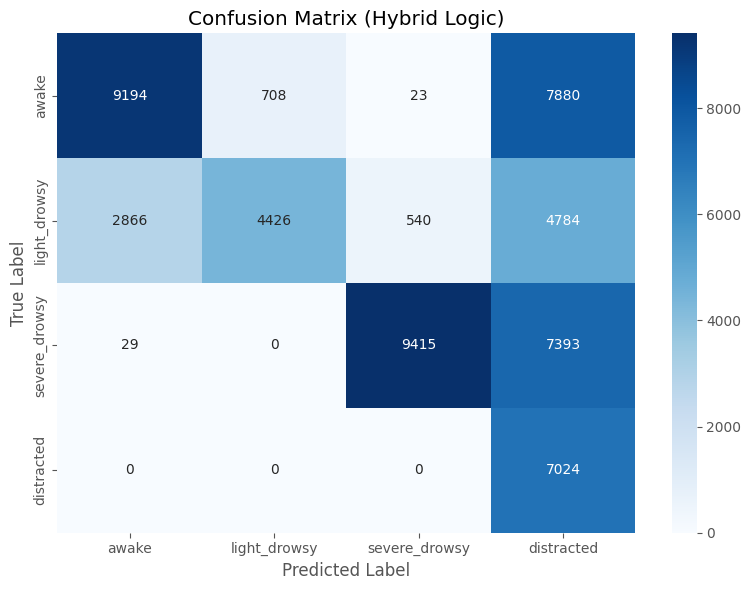

In [15]:
"""测试模型并计算详细指标"""
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 加载模型
model_path = "best_lstm_model_optimized.pth"  # 确保加载的是最新保存的模型
checkpoint = torch.load(model_path, map_location=DEVICE)
model = LSTMModel(
    checkpoint["input_size"],
    checkpoint["hidden_size"],
    checkpoint["num_layers"],
    checkpoint["num_classes"],
).to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"加载模型: {model_path}")

# 使用测试集
test_dataset = SequenceDataset(X_test_final, y_test_final)  # 使用 final 数据
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_BEST, shuffle=False)

# 预测
all_preds = []
all_labels = []

# === 设定规则阈值 ===
# 我们之前把 Yaw 特征放大了 15 倍。
# 归一化后的 Yaw 通常在 -1 到 1 之间。
# 分心时 Yaw 偏移很大，乘以 15 后，数值绝对值通常会 > 10。
# 我们设定一个保守阈值：5.0 (对应原始归一化值的 0.33，即大约 1个标准差的偏移)
YAW_THRESHOLD = 5.0

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(DEVICE)

        # 1. LSTM 模型预测 (主要负责看眼睛)
        outputs = model(sequences)
        _, predicted = outputs.max(1)

        # 2. 规则层介入 (强制修正分心)
        # 获取 Yaw 特征 (Batch, Seq_Len, Features)
        # Index 5 是 Yaw
        # 我们取序列的平均 Yaw 值来判断
        yaw_features = sequences[:, :, 5].mean(dim=1)

        # 如果 Yaw 绝对值超过阈值，强制判定为 Distracted (Index 3)
        # 3 是 CLASS_NAMES 中的 "distracted"
        is_distracted = torch.abs(yaw_features) > YAW_THRESHOLD
        predicted[is_distracted] = 3

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 分类报告
print("\n分类报告 (混合决策逻辑):")
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix (Hybrid Logic)")
plt.tight_layout()
plt.show()

In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
import pandas as pd

# ==========================================
# 1. 绘制多分类 ROC 曲线
# ==========================================
# 将标签二值化
y_test_bin = label_binarize(all_labels, classes=range(NUM_CLASSES))
n_classes = y_test_bin.shape[1]
all_probs_np = np.array(all_probs)

# 计算每一类的ROC曲线和AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
colors = ["blue", "red", "green", "orange"]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=2,
        label=f"ROC curve of {CLASS_NAMES[i]} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [54282, 55272]

<Figure size 1000x800 with 0 Axes>

正在计算 t-SNE (可能需要一点时间)...


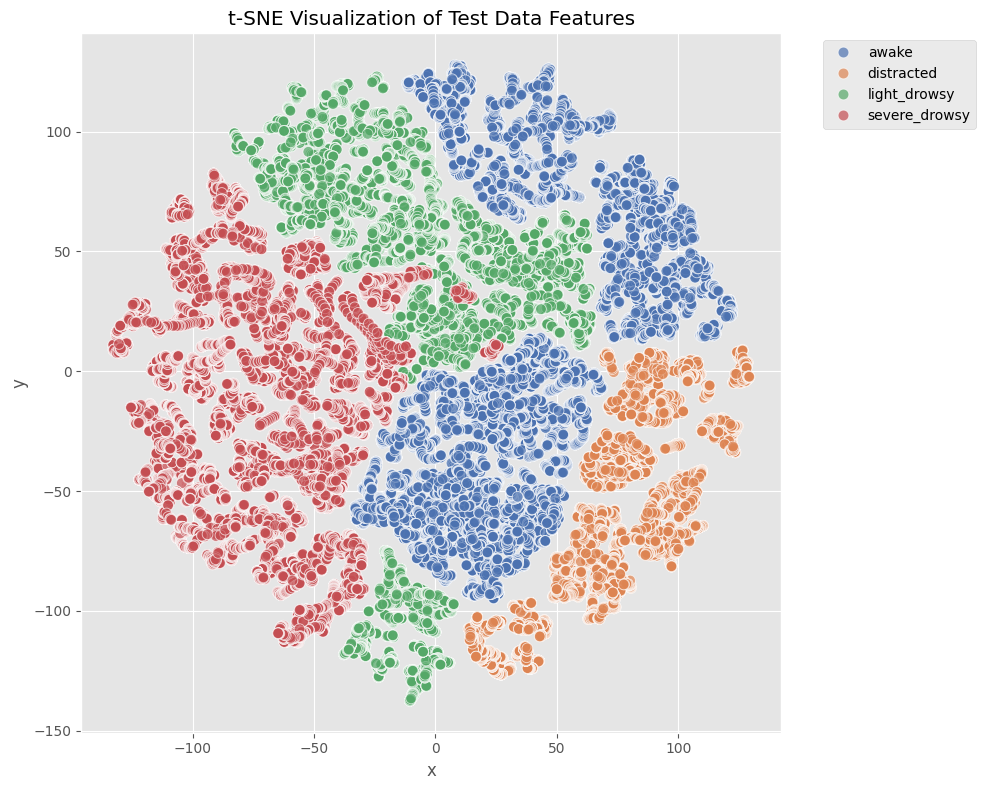

In [ ]:
# ==========================================
# 2. t-SNE 特征可视化
# ==========================================
print("正在计算 t-SNE (可能需要一点时间)...")

# 为了可视化，我们将时间序列特征取平均值，从 (N, 15, Features) -> (N, Features)
# 这样可以看到在特征空间中，不同类别的样本是否聚集在一起
X_test_flat = X_test.mean(axis=1)

# 使用 t-SNE 降维到 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_test_flat)

# 创建 DataFrame 方便绘图
df_tsne = pd.DataFrame(X_embedded, columns=["x", "y"])
df_tsne["label"] = [CLASS_NAMES[i] for i in all_labels]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_tsne, x="x", y="y", hue="label", palette="deep", s=60, alpha=0.7
)
plt.title("t-SNE Visualization of Test Data Features")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

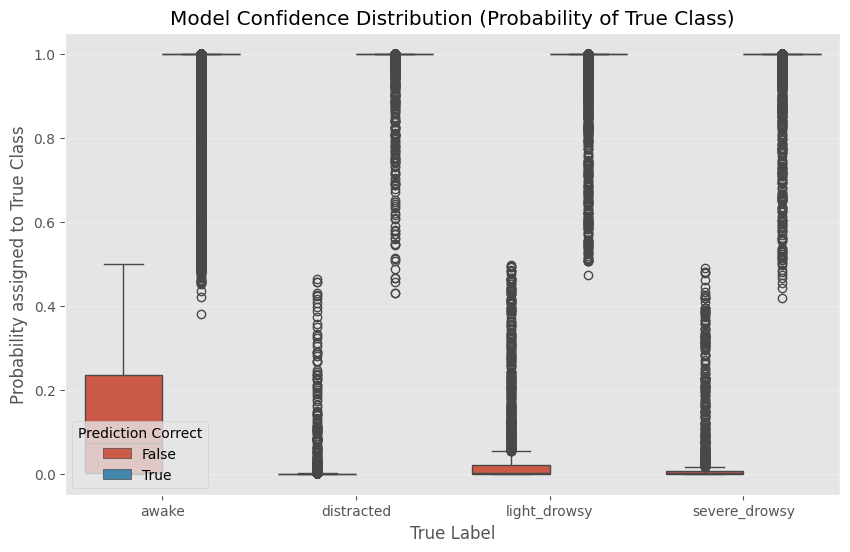

In [ ]:
# ==========================================
# 3. 预测置信度分布 (Boxplot)
# ==========================================
# 查看模型对每个类别的预测概率分布情况
# 理想情况下，正确类别的概率应该很高
prob_df = pd.DataFrame(
    {
        "True Label": [CLASS_NAMES[i] for i in all_labels],
        "Predicted Probability": [
            probs[label] for probs, label in zip(all_probs, all_labels)
        ],
        "Prediction Correct": [p == l for p, l in zip(all_preds, all_labels)],
    }
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="True Label", y="Predicted Probability", hue="Prediction Correct", data=prob_df
)
plt.title("Model Confidence Distribution (Probability of True Class)")
plt.ylabel("Probability assigned to True Class")
plt.grid(True, axis="y", alpha=0.3)
plt.show()